In [2]:
!pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Activation
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [5]:
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
import io
%cd "C:\Users\harik\Downloads\ML Projects"

C:\Users\harik\Downloads\ML Projects


In [7]:
df = pd.read_csv("youtube_data.csv")

In [8]:
df = df.dropna()

In [9]:
classes = ['travel', 'science and technology', 'food', 'manufacturing', 'history', 'art and music']

In [10]:
strToInt = {'travel': 0,
            'science and technology': 1,
            'food': 2,
            'manufacturing': 3,
            'history': 4,
            'art and music': 5}

In [11]:
X = df.drop(labels=["Category", "Video Id"], axis=1)
y = df["Category"]
X = X.reset_index()
y = y.reset_index()
y = y["Category"]

In [12]:
for i in range(len(y)):
    if y[i] in strToInt:
        y[i] = strToInt[y[i]]

In [13]:
y = to_categorical(y, num_classes=len(classes))

In [14]:
training_text = []

In [15]:
for i in range(len(X)):
    training_text.append(X["Title"][i]+" "+X["Description"][i])

In [16]:
stop_words = stopwords.words("english")

In [17]:
lemmatizer = WordNetLemmatizer()

In [18]:
xtrain = []
for sent in training_text:
    sent = re.sub("[^a-zA-Z]", " ", sent)
    ent = sent.lower().split()
    sent = [lemmatizer.lemmatize(word) for word in sent if word not in set(stop_words)]
    sent = " ".join(sent)
    xtrain.append(sent)

In [19]:
paddingLen = 70
maxFeatureLen = 20
vocabSize = 10000

In [20]:
oneHotEncoded = [one_hot(word, vocabSize) for word in xtrain]

In [21]:
oneHotEncoded = pad_sequences(oneHotEncoded, 
                        truncating="post", padding="post",
                        maxlen=paddingLen)

In [22]:
oneHotEncoded = np.array(oneHotEncoded)
X, y = shuffle(oneHotEncoded, y, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# creating model

In [23]:
model = Sequential()
model.add(Embedding(vocabSize, maxFeatureLen, input_length=paddingLen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(units=128))
model.add(Dense(units=len(classes)))
model.add(Activation("softmax"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 20)            200000    
                                                                 
 spatial_dropout1d (Spatial  (None, 70, 20)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 70, 128)           76288     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
 activation (Activation)     (None, 6)                 0         
                                                        

In [24]:
hist = model.fit(X_train, y_train, batch_size=24, epochs=10,
                        validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
334/334 [==============================] - 77s 200ms/step - loss: 0.4579 - accuracy: 0.1656 - val_loss: 0.4511 - val_accuracy: 0.1675
Epoch 2/10
334/334 [==============================] - 64s 193ms/step - loss: 0.4515 - accuracy: 0.1753 - val_loss: 0.4502 - val_accuracy: 0.2000
Epoch 3/10
334/334 [==============================] - 66s 199ms/step - loss: 0.4494 - accuracy: 0.1875 - val_loss: 0.4461 - val_accuracy: 0.1960
Epoch 4/10
334/334 [==============================] - 66s 199ms/step - loss: 0.4469 - accuracy: 0.1981 - val_loss: 0.4391 - val_accuracy: 0.2795
Epoch 5/10
334/334 [==============================] - 66s 199ms/step - loss: 0.4438 - accuracy: 0.2225 - val_loss: 0.4444 - val_accuracy: 0.2410
Epoch 6/10
334/334 [==============================] - 63s 189ms/step - loss: 0.4445 - accuracy: 0.2273 - val_loss: 0.4459 - val_accuracy: 0.2275
Epoch 7/10
334/334 [==============================] - 68s 203ms/step - loss: 0.4439 - accuracy: 0.2303 - val_loss: 0.4419 - val_ac

In [25]:
train_loss = hist.history["loss"]
train_accuracy = hist.history["accuracy"]
val_loss = hist.history["val_loss"]
val_accuracy = hist.history["val_accuracy"]

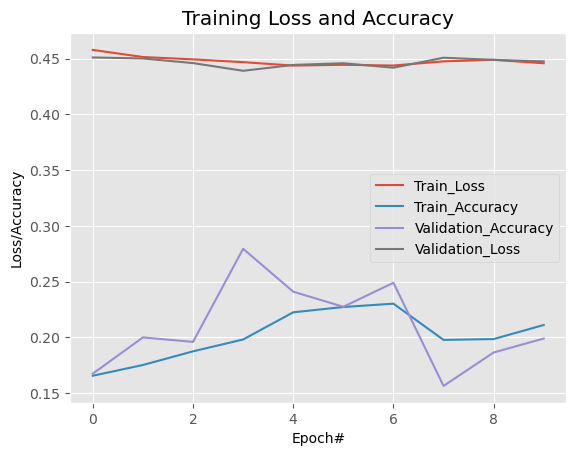

In [26]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,10),train_loss,label="Train_Loss")
plt.plot(np.arange(0,10),train_accuracy,label="Train_Accuracy")
plt.plot(np.arange(0,10),val_accuracy,label="Validation_Accuracy")
plt.plot(np.arange(0,10),val_loss,label="Validation_Loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch#")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("output.png")
plt.show()
plt.close()